# Diluted Unitary Fitting, Analysis

Plotting the spectra of Diluted Unitaries [fitted on the spectra](Diluted_Unitary_Fitting_Three_Qubits.ipynb) of [repeated quantum ciruits](../experiments/Map_Retrival_Repeated_PQC_3qubits.ipynb).

In [3]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from quantum_channel import channel_spectrum
from kraus_channels import KrausMap, DilutedKrausMap
from utils import loader, saver
from quantum_tools import generate_haar_random, reshuffle

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from matplotlib import rc
#rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

In [ ]:
def resample_diluted(diluted_model, num_samples, rng):
    """
    Resample diluted unitary spectrum with parameters in diluted_model.
    """
    d = diluted_model.channel.d
    c = diluted_model.channel.c
    rank = diluted_model.channel.rank
    spectrum_resample_list = []
    for i in range(num_samples):
        diluted_resample = DilutedKrausMap(U=generate_haar_random(d, rng=rng), c=c, kraus_part=KrausMap(d, rank = rank))
        spectrum_resample = channel_spectrum(diluted_resample, keep_unity=False)
        spectrum_resample_list.append(spectrum_resample)
    
    spectrum_resample = np.real(np.concatenate(spectrum_resample_list))
    
    return spectrum_resample

path1 = "../experiments/data/"
path2 = "data/"

## Load Fitted Diluted Unitary Models

In [5]:
[channel_list1, channel_list2, channel_list3, channel_list4, channel_list5, channel_list6, channel_list7] = loader(path1 + "channel_fullRank_belem_longTrain.p")

spectrum_target_list1 = [channel_spectrum(channel, keep_unity=False) for channel in channel_list1]
spectrum_target_list2 = [channel_spectrum(channel, keep_unity=False) for channel in channel_list2]
spectrum_target_list3 = [channel_spectrum(channel, keep_unity=False) for channel in channel_list3]
spectrum_target_list4 = [channel_spectrum(channel, keep_unity=False) for channel in channel_list4]
spectrum_target_list5 = [channel_spectrum(channel, keep_unity=False) for channel in channel_list5]

In [6]:
[distance_best_list1, model_best_list1] = loader(path1 + "diluted_fitting_8layer.model")
[distance_best_list2, model_best_list2] = loader(path1 + "diluted_fitting_16layer.model")
[distance_best_list3, model_best_list3] = loader(path1 + "diluted_fitting_24layer.model")
[distance_best_list4, model_best_list4] = loader(path1 + "diluted_fitting_32layer.model")
[distance_best_list5, model_best_list5] = loader(path2 + "diluted_fitting_3qubit_40layer.model")

In [7]:
print(f"Mean Error, Std Error, Max Error, Min Error")
print(f"{np.mean(distance_best_list1):.4f}, {np.std(distance_best_list1):.4f}, {np.max(distance_best_list1):.4f}, {np.min(distance_best_list1):.4f}")
print(f"{np.mean(distance_best_list2):.4f}, {np.std(distance_best_list2):.4f}, {np.max(distance_best_list2):.4f}, {np.min(distance_best_list2):.4f}")
print(f"{np.mean(distance_best_list3):.4f}, {np.std(distance_best_list3):.4f}, {np.max(distance_best_list3):.4f}, {np.min(distance_best_list3):.4f}")
print(f"{np.mean(distance_best_list4):.4f}, {np.std(distance_best_list4):.4f}, {np.max(distance_best_list4):.4f}, {np.min(distance_best_list4):.4f}")
print(f"{np.mean(distance_best_list5):.4f}, {np.std(distance_best_list5):.4f}, {np.max(distance_best_list5):.4f}, {np.min(distance_best_list5):.4f}")


Mean Error, Std Error, Max Error, Min Error
0.0006, 0.0006, 0.0022, 0.0001
0.0025, 0.0019, 0.0055, 0.0001
0.0019, 0.0018, 0.0061, 0.0002
0.0011, 0.0013, 0.0043, 0.0001
-0.1202, 0.0078, -0.1103, -0.1376


In [8]:
for i, channel in enumerate(channel_list1):
    map = reshuffle(channel.choi)
    np.savetxt(f"data/superOp_threeQubits_8Layers_{i}.txt", map, fmt='%f')

for i, channel in enumerate(channel_list2):
    map = reshuffle(channel.choi)
    np.savetxt(f"data/superOp_threeQubits_16Layers_{i}.txt", map, fmt='%f')

for i, channel in enumerate(channel_list3):
    map = reshuffle(channel.choi)
    np.savetxt(f"data/superOp_threeQubits_24Layers_{i}.txt", map, fmt='%f')

for i, channel in enumerate(channel_list4):
    map = reshuffle(channel.choi)
    np.savetxt(f"data/superOp_threeQubits_32Layers_{i}.txt", map, fmt='%f')

for i, channel in enumerate(channel_list5):
    map = reshuffle(channel.choi)
    np.savetxt(f"data/superOp_threeQubits_40Layers_{i}.txt", map, fmt='%f')   

## Diluted Unitary comparison with Real Data

In [9]:
def annulus_radius(rank, p, sign = "pos"):
    if sign == "pos":
        r = np.sqrt((1-p)**2 + p**2/rank)
    else:
        r = np.sqrt((1-p)**2 - p**2/rank)

    return r

def plot_spectrum(diluted_model_list, spectrum_target_list, filename, yticks_on = True, label = True, title = None):
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    rng = np.random.default_rng(seed=42)

    r_max_list = []
    r_min_list = []
    rank_list = []
    p_list = []

    spectrum_resample_list = []
    for diluted_model in diluted_model_list:
        rank = diluted_model.channel.rank
        rank_list.append(rank)
        p = 1 - diluted_model.channel.c
        p_list.append(p)

        r_max_list.append(annulus_radius(rank, p, sign="pos"))
        r_min_list.append(annulus_radius(rank, p, sign="neg"))

        spectrum_resample = resample_diluted(diluted_model, num_samples = 1, rng=rng)
        spectrum_resample_list.append(spectrum_resample)

    rank = np.mean(rank_list)
    p = np.mean(p_list)
    r_max = np.mean(r_max_list)
    r_min = np.mean(r_min_list)

    fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')
    plt.title(title, fontsize=16)

    for spectrum, spectrum_resample in zip(spectrum_target_list, spectrum_resample_list):
        spectrum = np.real(spectrum)
        spectrum_resample = np.real(spectrum_resample)
        spectrum = spectrum[spectrum[:,1]>0]
        spectrum_resample = spectrum_resample[spectrum_resample[:,1]<0]

        plt.plot(spectrum[:,0], spectrum[:,1], "o", color = "black", markersize=1)
        plt.plot(spectrum_resample[:,0], spectrum_resample[:,1], "o", color="gray", markersize=1)

    #plot text with rank and p top left
    t = np.linspace(0, 2*np.pi, 100)
    plt.plot(r_max * np.cos(t), r_max * np.sin(t), color="black", linewidth=0.7)
    plt.plot(r_min * np.cos(t), r_min * np.sin(t), color="black", linewidth=0.7)
    plt.text(-0.8, 0.8, f"$p = {p:.2f}$", fontsize=16)
    plt.text(-0.8, 0.65, f"$r = {rank}$", fontsize=16)


    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

    plt.xticks([-1, -0.5, 0, 0.5, 1], fontsize=16)
    plt.xlabel("$\mathrm{Re}\lambda$", fontsize=16)
        
    if yticks_on:
        plt.yticks([-1, -0.5, 0, 0.5, 1], fontsize=16)
        plt.ylabel("$\mathrm{Im}\lambda$", fontsize=16)
    else:
        plt.yticks([], [])
    if label:
        plt.legend(["Retrieved Map", "Diluted Unitary"], fontsize=16, loc='lower left', frameon=False, markerscale=4)
    
    plt.savefig("figures/" + filename + ".svg", bbox_inches='tight')
    plt.show()

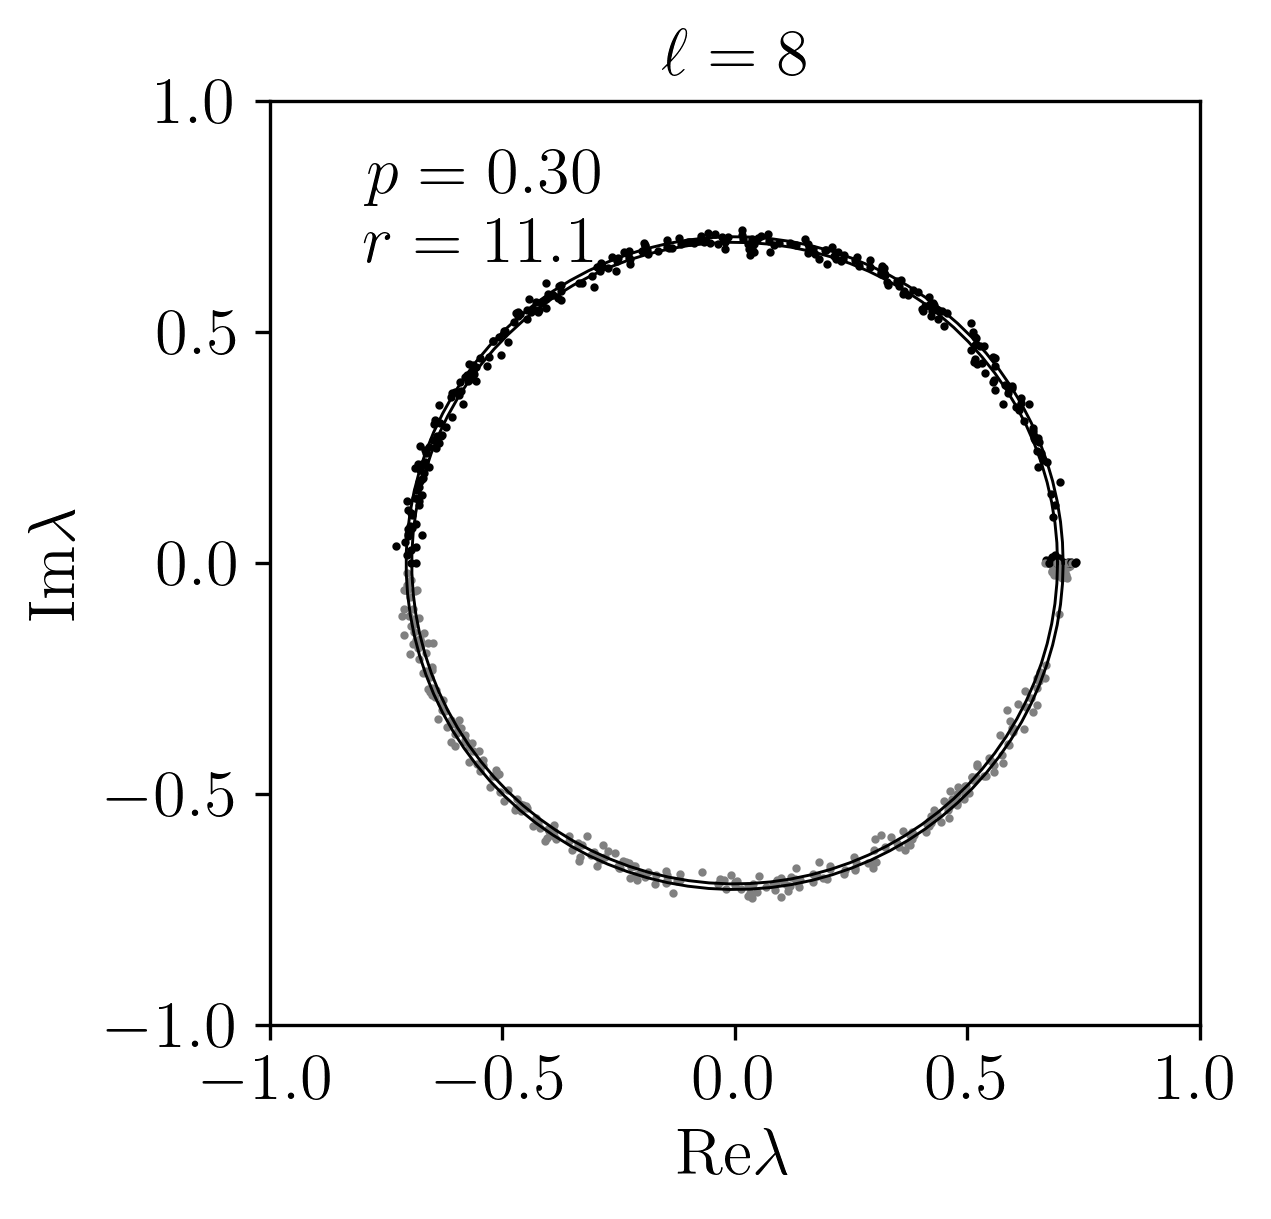

In [10]:
plot_spectrum(model_best_list1, spectrum_target_list1, "diluted_fitting_3qubit_8layer", label=False, title="$\ell = 8$")

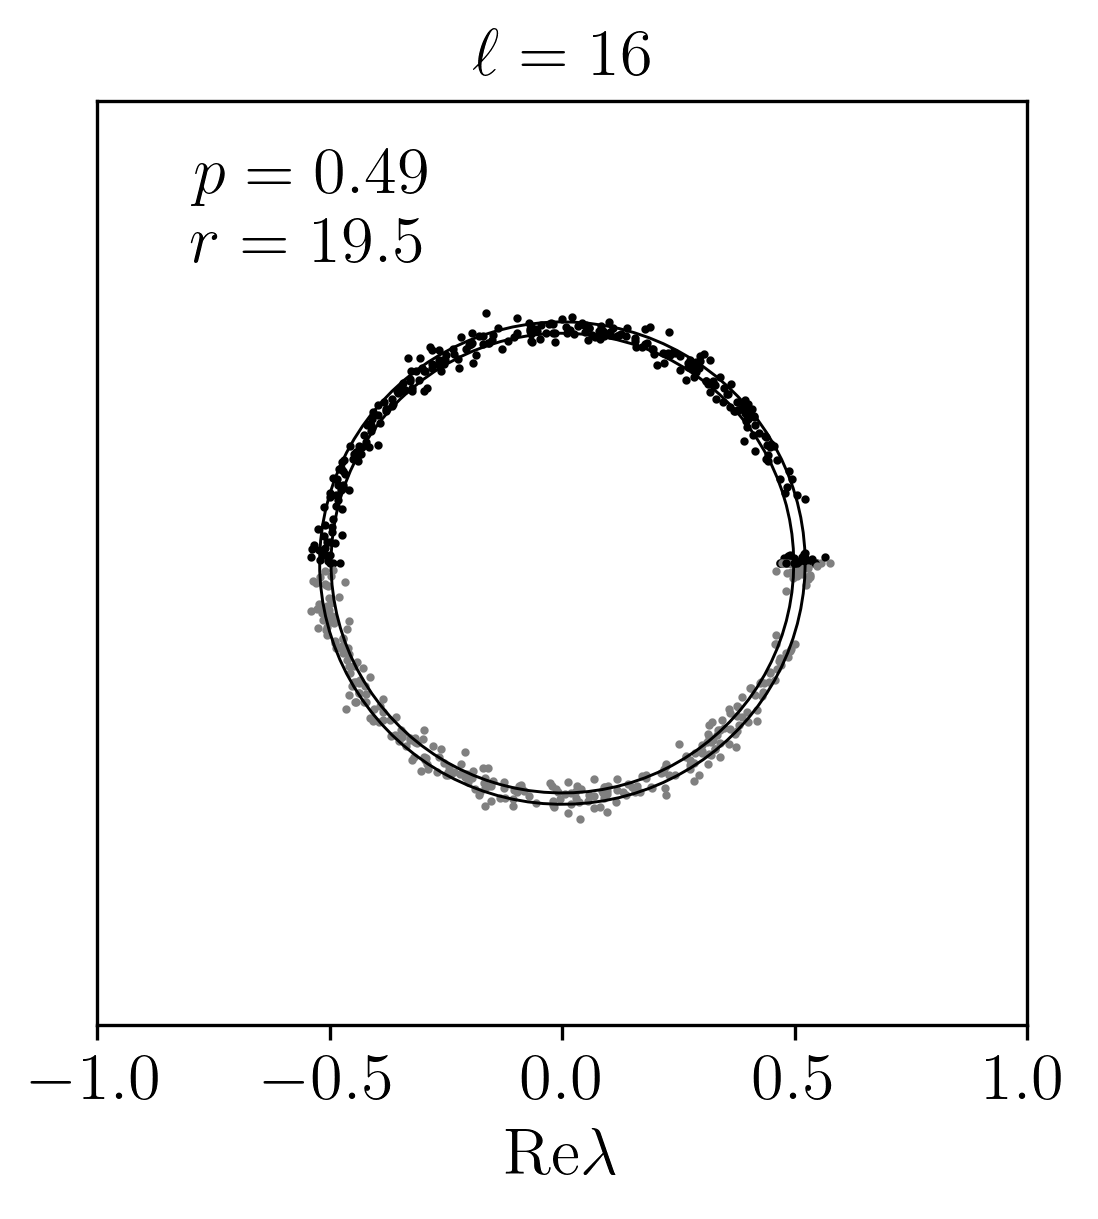

In [11]:
plot_spectrum(model_best_list2, spectrum_target_list2, "diluted_fitting_3qubit_16layer", yticks_on=False, label=False, title="$\ell = 16$")

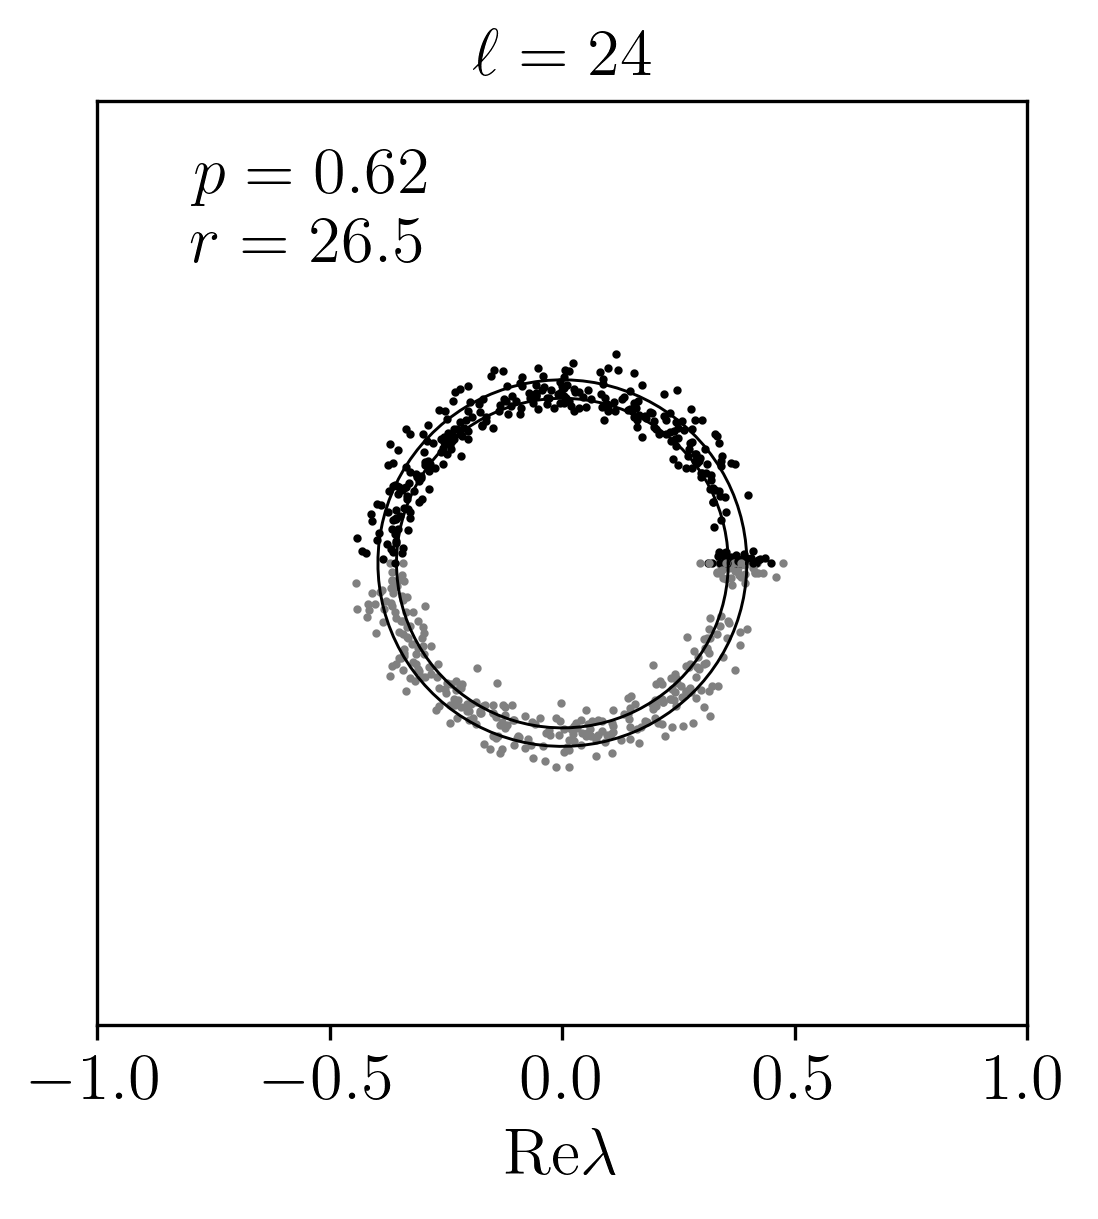

In [12]:
plot_spectrum(model_best_list3, spectrum_target_list3, "diluted_fitting_3qubit_24layer", yticks_on=False, label=False, title="$\ell = 24$")

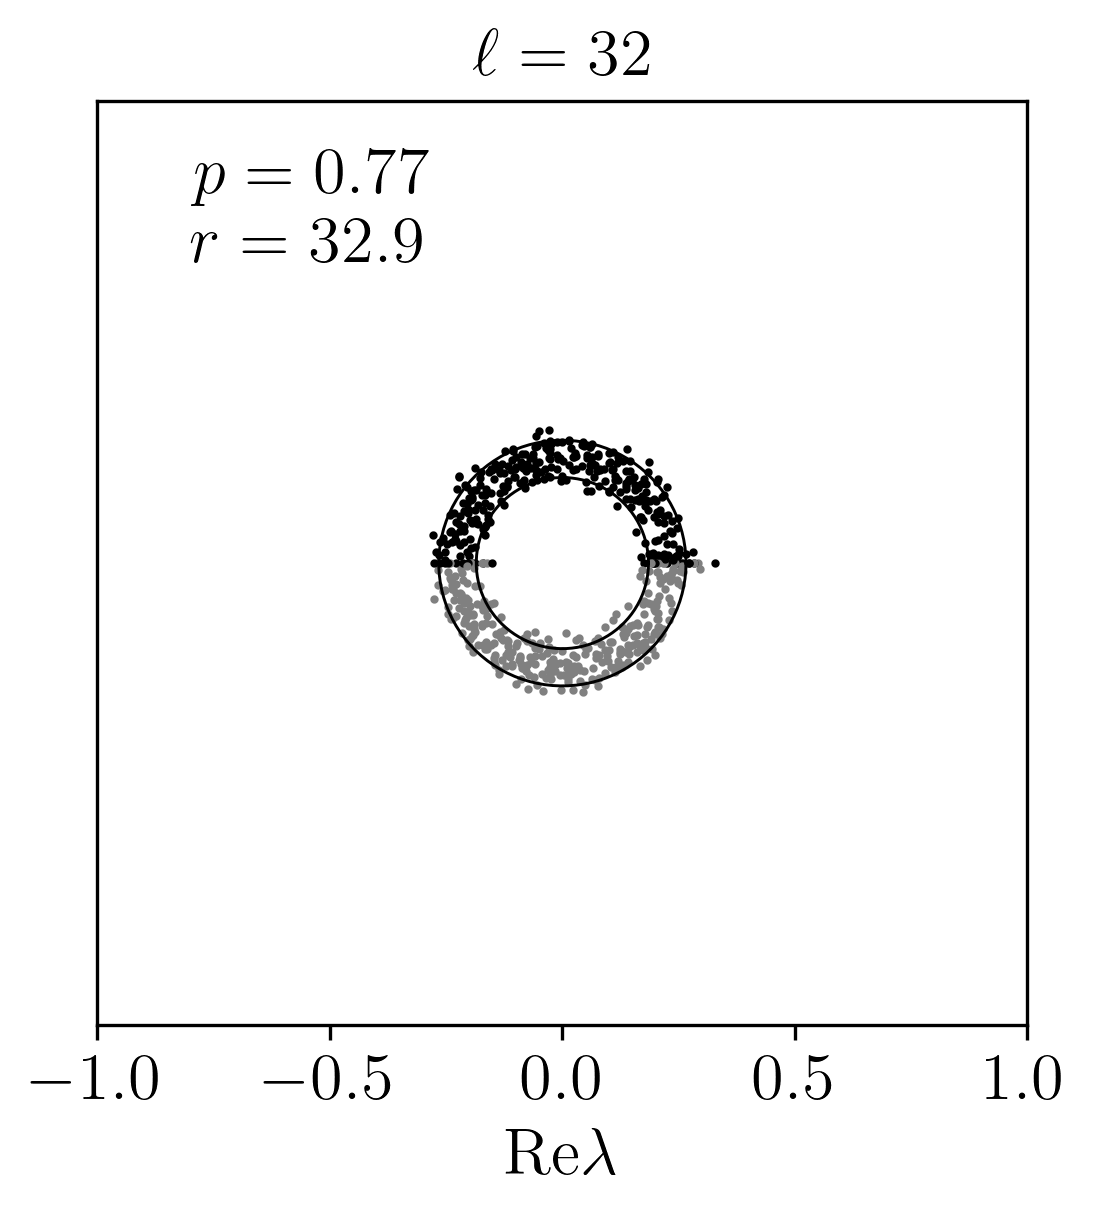

In [13]:
plot_spectrum(model_best_list4, spectrum_target_list4, "diluted_fitting_3qubit_32layer", yticks_on=False, label=False, title="$\ell = 32$")

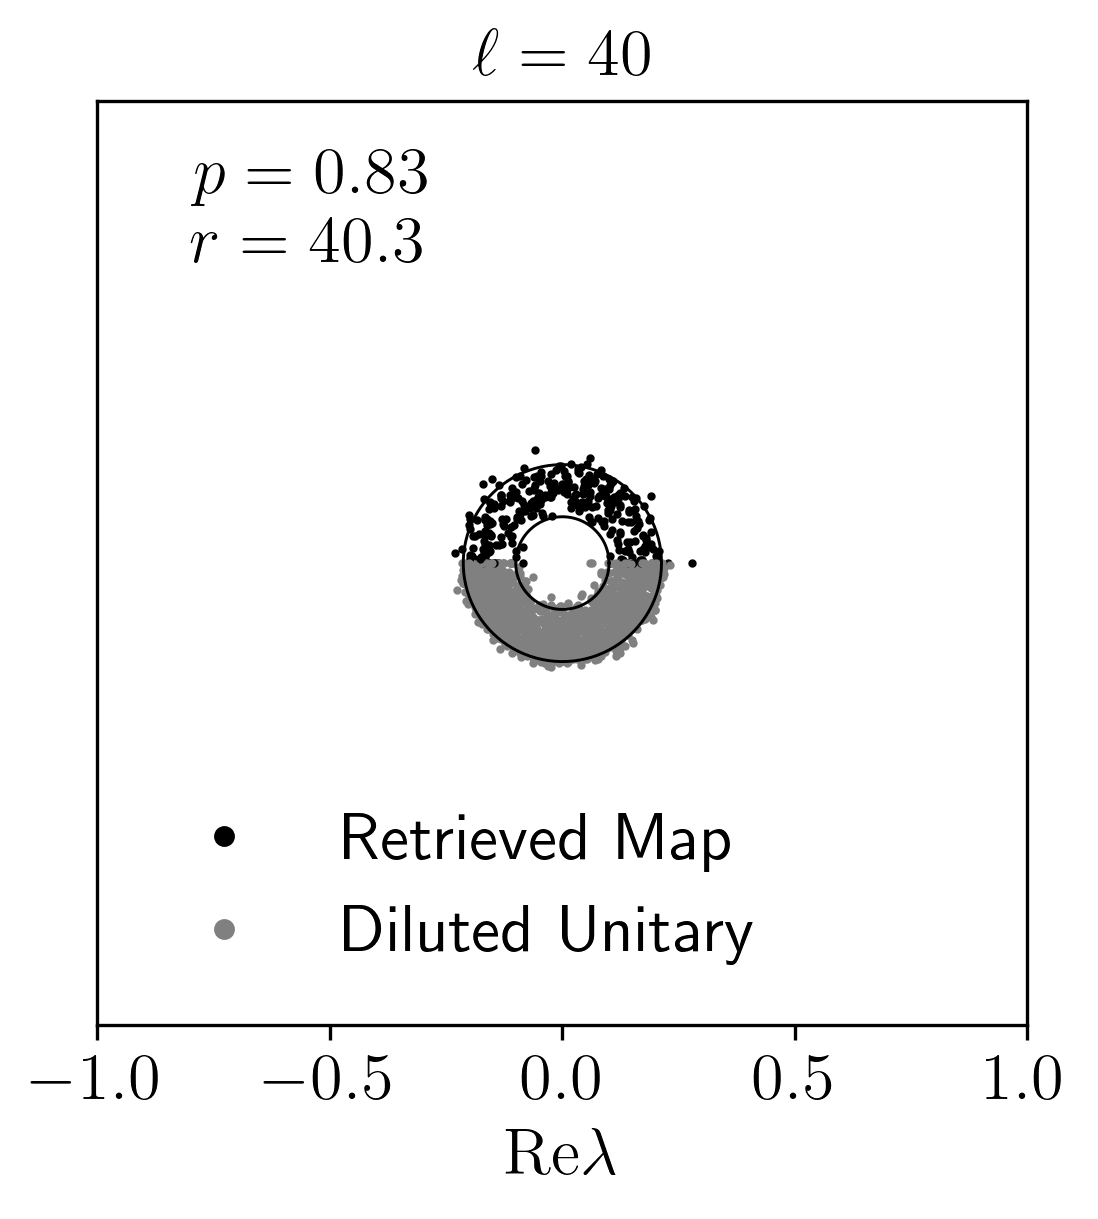

In [14]:
plot_spectrum(model_best_list5, spectrum_target_list5, "diluted_fitting_3qubit_40layer.model", yticks_on=False, label=True, title="$\ell = 40$")

## Dump data

In [142]:
super_op1 = reshuffle(model1.channel.choi)
super_op2 = reshuffle(model2.channel.choi)
super_op3 = reshuffle(model3.channel.choi)
super_op4 = reshuffle(model4.channel.choi)
super_op5 = reshuffle(model5.channel.choi)

np.savetxt("data/superOp_1.txt", super_op1, fmt='%f')
np.savetxt("data/superOp_2.txt", super_op2, fmt='%f')
np.savetxt("data/superOp_3.txt", super_op3, fmt='%f')
np.savetxt("data/superOp_4.txt", super_op4, fmt='%f')
np.savetxt("data/superOp_5.txt", super_op5, fmt='%f')

NameError: name 'model1' is not defined